# Modeling implicit bias with Fuzzy Cognitive Maps

In [1]:
import sys
import numpy as np
import numpy.linalg as la
import pandas as pd
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
paper_rc = {'lines.linewidth': 1, 'lines.markersize': 7} 
sns.set_context('paper', font_scale=1.4, rc=paper_rc)
                   
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

## Load the correlation matrix

The correlation is determined using three different but conceptually sound statistical tools. The Pearson correlation coefficient is used to measure correlation between the numeric features. The Cramer's V is used to capture the association strength between nominal features. Finally, we use the R-squared coefficient of determination to measure the percentage of variation in the numeric features that is explained by the protected nominal features coupled with an F-test of joint significance. The selected measures are chosen to preserve consistency since they are related to the Pearson's correlation coefficient (even though features do not meet the assumptions of normality, linear dependence or homoscedasticity).

In [3]:
df = abs(pd.read_csv('correlation.csv'))
W0 = df.to_numpy().reshape(len(df.columns), len(df.columns))

names = df.columns.tolist()

## Fuzzy Cognitive Maps

Fuzzy Cognitive Maps (FCMs) are recurrent neural networks consisting of neural concepts and signed weighted connections. FCMs allow modeling complex systems in terms of causal relationships and well-defined concepts.Neural concepts represent variables, states, entities related to the physical system under investigation. The signed weight associated with each connection denotes the causality (or association in general) strength between the neurons. Weights can be quantified in the $[-1, 1]$ interval, while that neuron's activation values can take values in either $[0,1]$ or $[-1, 1]$ depending on the nonlinear transfer function attached to each neuron.

In each iteration, an FCM model produces an activation vector $A_k^{(t)}=[a_{k1}^{(t)}, \ldots, a_{ki}^{(t)}, \ldots, a_{kM}^{(t)}]$ where $a_{ki}^{(t)}$ is the activation value of the $i$-th neural entity in the $t$-th iteration, given the $k$-th initial stimulus. The following equation displays the recurrent reasoning rule of this model,

$A_k^{(t)} = f \left(A_k^{(t-1)}W \right)$

where $M$ denotes the number of neurons and $W_{M \times M}$ is the weight matrix such that $w_{ji}$ represents the weight connecting the $C_j$ and $C_i$ neurons, while $f(\cdot)$ is the transfer function used to keep the neurons' activation values within the allowed activation interval. This reasoning rule often converges to unique-foxed point attracors, which lead to models with limited simulation capabilities. Being more explicit, if the network converges to a unique fixed point, then the model will produce the same solutions regardless of the values used to activate the neurons.

To tackle the previous limitation, we can introduce a nonlinearity coefficient $\phi \in [0,1]$ controlling the extent to which the model will take into account the value produced by the transfer function over the neuron's initial activation value. This can be done as follows:

$A_k^{(t)} = \phi f \left( A_k^{(t-1)}W \right)+ (1-\phi) A_k^{(0)}$.

If $\phi=1$, then we have a traditional long-term recurrent model such that the neuron's activation value depends on the states of connected neurons. If $\phi=0$, then there will be no recurrence at all, so the model will narrow down to one linear regression with multiple outputs. The intuition of this model is that long-term recurrent models often forget the initial conditions after a few iterations, which leads to models with poor discriminatory power. On the other hand, some decision models might benefit from a certain degree of linearity.

In [4]:
"""Sigmoid transfer function"""
def sigmoid(A, l=1, h=0):
    return 1.0 / (1.0 + np.exp(-l*(A-h)))

"""Hyperbolic transfer function"""
def hyperbolic(A):
    return np.tanh(A)

"""Rescaled transfer function"""
def rescaled(A):
    if la.norm(A)==0.0:
        return np.zeros(A.shape)
    else:
        return A / la.norm(A)

"""Recurrent reasoning process"""
def reasoning(W, A, T=50, phi=0.8, plot=True, indexes=[0,12], case="age", function=rescaled):
    
    states = np.zeros([len(A), T, len(W)])
    states[:,0,:] = A
    
    for t in range(1,T):
        A = states[:,t,:] = (phi * function(np.matmul(A, W)) + (1-phi) * states[:,0,:])

    if plot:
        
        plt.figure(figsize=(6,4))
        
        for idx in indexes:
            for i in range(len(states)):
                val = plt.plot(states[i,:,idx], label=names[idx], marker='o')

                plt.xlabel(r'$t$', fontsize=14)
                plt.ylabel(r'$a_i^{(t)}$', fontsize=14)
                plt.ylim(0, 0.35)
        
        ax = plt.gca()
        ax.xaxis.get_major_locator().set_params(integer=True)
        plt.legend(loc='best')
        plt.margins(x=0)
        plt.savefig(case + "_A_" + str(phi) + ".pdf")
        plt.show()        
    
        return A
    else:
        return states

## Numerical simulations

The validation of this FCM-based model is two-fold. First, we need to make sure that we can produce simulation results that do not lead to a unique fixed-point (this can be done experimentally for a limited number of scenarios or analytically). Second, we need to verify that the model produces reasonable results given expected patterns. For example, we noticed that the variables `existing credits (F9)`, `employment since (F14)` and `residence since (F15)` show the highest correlation with the protected variable `age`. Meanwhile, the variables `other debtors (F11)`, `property (F16)` and `purpose (F17)` show the largest correlation with the protected variable `foreign worker`. Finally, `housing (F6)`, `people liable (F10)`, `employment since (F14)` and `purpose (F17)` show the largest correlation with the protected variable `gender`.

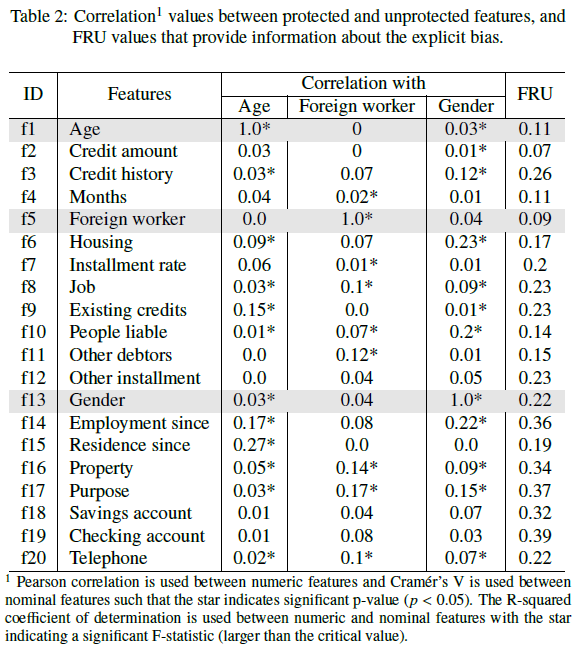

## Scenario analysis - bias towards age

We will run several scenarios to verify that the model produces reasonable results. In the first scenario, we randomly activate the variables having the largest correlation with the protected features `age`. We do this 20 times, effectively generating 20 input vectors. The simulation results are shown below.

phi = 0.6


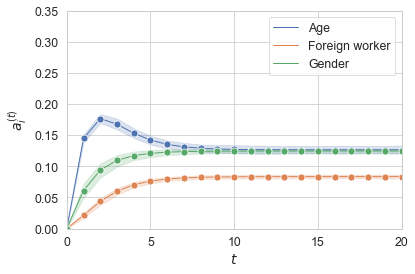

phi = 0.8


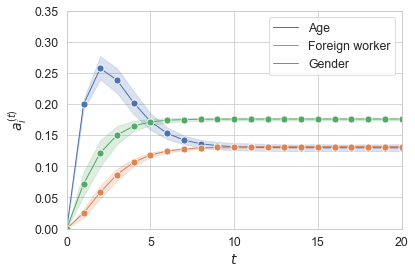

phi = 1


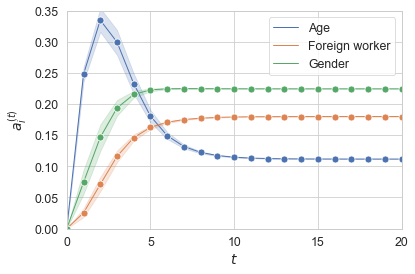

In [5]:
case = "age"
phi_values = [0.6, 0.8, 1]

for phi in phi_values:
    
    df = pd.DataFrame(columns=["var","t","value"])
    
    for i in range(20):
        
        f9 = np.random.uniform(0.0,1.0)
        f14 = np.random.uniform(0.0,1.0)
        f15 = np.random.uniform(0.0,1.0)
        
        A = np.array([[0, 0, 0, 0, 0, 0, 0, 0, f9, 0, 0, 0, 0, f14, f15, 0, 0, 0, 0, 0]])
        
        state = reasoning(W0, A, phi=phi, T=21, plot=False)

        data_age = state[0,:,0]
        data_foreign = state[0,:,4]
        data_gender = state[0,:,12]
        
        df1 = pd.DataFrame(columns=["var","t","value"])
        df1["t"] = range(len(data_age))
        df1["value"] = data_age.tolist()
        df1["var"] = "Age"
        
        df2 = pd.DataFrame(columns=["var","t","value"])
        df2["t"] = range(len(data_foreign))
        df2["value"] = data_foreign.tolist()
        df2["var"] = "Foreign worker"
        
        df3 = pd.DataFrame(columns=["var","t","value"])
        df3["t"] = range(len(data_gender))
        df3["value"] = data_gender.tolist()
        df3["var"] = "Gender"
        
        df = pd.concat([df,df1,df2,df3], ignore_index=True)
    
    plt.figure(figsize=(6,4))
    ax = plt.gca()
    sns.lineplot(data=df, x="t", y="value", hue="var", ax=ax, marker='o')
    plt.xlabel(r'$t$', fontsize=14)
    plt.ylabel(r'$a_i^{(t)}$', fontsize=14)
    plt.ylim(0, 0.35)
    ax.xaxis.get_major_locator().set_params(integer=True)
    plt.legend(loc='best')
    plt.margins(x=0)
    plt.savefig(case + "_A_" + str(phi) + ".pdf", bbox_inches='tight')
    print('phi =', phi)
    plt.show()

## Scenario analysis - bias towards foreign worker

We will run several scenarios to verify that the model produces reasonable results. In the first scenario, we randomly activate the variables having the largest correlation with the protected features `foreign worker`. We do this 20 times, effectively generating 20 input vectors. The simulation results are shown below.


phi = 0.6


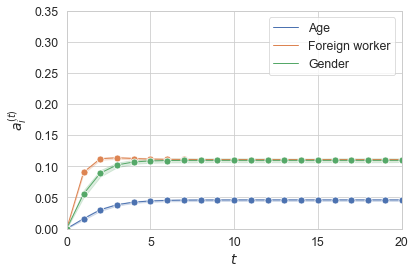

phi = 0.8


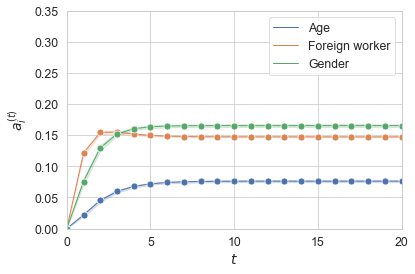

phi = 1


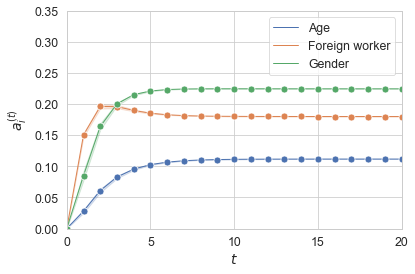

In [6]:
case = "foreign"
phi_values = [0.6, 0.8, 1]

for phi in phi_values:
    
    df = pd.DataFrame(columns=["var","t","value"])
    
    for i in range(20):
        
        f11 = np.random.uniform(0.0,1.0)
        f16 = np.random.uniform(0.0,1.0)
        f17 = np.random.uniform(0.0,1.0)
        
        A = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, f11, 0, 0, 0, 0, f16, f17, 0, 0, 0]])
        
        state = reasoning(W0, A, phi=phi, T=21, plot=False)

        data_age = state[0,:,0]
        data_foreign = state[0,:,4]
        data_gender = state[0,:,12]
        
        df1 = pd.DataFrame(columns=["var","t","value"])
        df1["t"] = range(len(data_age))
        df1["value"] = data_age.tolist()
        df1["var"] = "Age"
        
        df2 = pd.DataFrame(columns=["var","t","value"])
        df2["t"] = range(len(data_foreign))
        df2["value"] = data_foreign.tolist()
        df2["var"] = "Foreign worker"
        
        df3 = pd.DataFrame(columns=["var","t","value"])
        df3["t"] = range(len(data_gender))
        df3["value"] = data_gender.tolist()
        df3["var"] = "Gender"
        
        df = pd.concat([df,df1,df2,df3], ignore_index=True)
    
    plt.figure(figsize=(6,4))
    ax = plt.gca()
    sns.lineplot(data=df, x="t", y="value", hue="var", ax=ax, marker='o')
    plt.xlabel(r'$t$', fontsize=14)
    plt.ylabel(r'$a_i^{(t)}$', fontsize=14)
    plt.ylim(0, 0.35)
    ax.xaxis.get_major_locator().set_params(integer=True)
    plt.legend(loc='best')
    plt.margins(x=0)
    plt.savefig(case + "_A_" + str(phi) + ".pdf", bbox_inches='tight')
    print('phi =', phi)
    plt.show()

## Scenario analysis - bias towards gender

We will run several scenarios to verify that the model produces reasonable results. In the third scenario, we randomly activate the variables having the largest correlation with the protected features `gender`. We do this 20 times, effectively generating 20 input vectors. The simulation results are shown below.

phi = 0.6


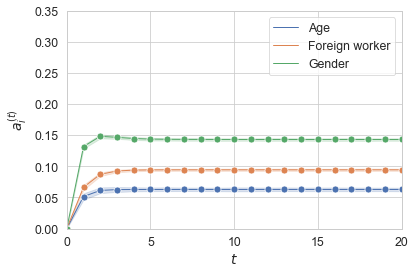

phi = 0.8


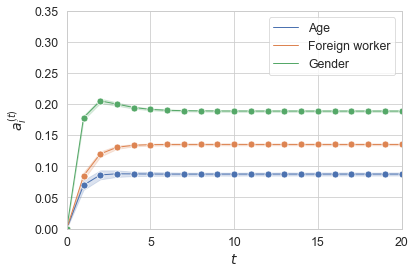

phi = 1


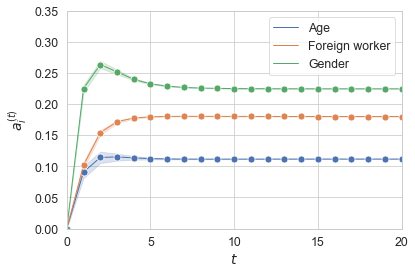

In [7]:
case = "gender"
phi_values = [0.6, 0.8, 1]

for phi in phi_values:
    
    df = pd.DataFrame(columns=["var","t","value"])
    
    for i in range(20):
        
        f6 = np.random.uniform(0.0,1.0)
        f10 = np.random.uniform(0.0,1.0)
        f14 = np.random.uniform(0.0,1.0)
        f17 = np.random.uniform(0.0,1.0)
        
        A = np.array([[0, 0, 0, 0, 0, f6, 0, 0, 0, f10, 0, 0, 0, f14, 0, 0, f17, 0, 0, 0]])
        
        state = reasoning(W0, A, phi=phi, T=21, plot=False)

        data_age = state[0,:,0]
        data_foreign = state[0,:,4]
        data_gender = state[0,:,12]
        
        df1 = pd.DataFrame(columns=["var","t","value"])
        df1["t"] = range(len(data_age))
        df1["value"] = data_age.tolist()
        df1["var"] = "Age"
        
        df2 = pd.DataFrame(columns=["var","t","value"])
        df2["t"] = range(len(data_foreign))
        df2["value"] = data_foreign.tolist()
        df2["var"] = "Foreign worker"
        
        df3 = pd.DataFrame(columns=["var","t","value"])
        df3["t"] = range(len(data_gender))
        df3["value"] = data_gender.tolist()
        df3["var"] = "Gender"
        
        df = pd.concat([df,df1,df2,df3], ignore_index=True)
    
    plt.figure(figsize=(6,4))
    ax = plt.gca()
    sns.lineplot(data=df, x="t", y="value", hue="var", ax=ax, marker='o')
    plt.xlabel(r'$t$', fontsize=14)
    plt.ylabel(r'$a_i^{(t)}$', fontsize=14)
    plt.ylim(0, 0.35)
    ax.xaxis.get_major_locator().set_params(integer=True)
    plt.legend(loc='best')
    plt.margins(x=0)
    plt.savefig(case + "_A_" + str(phi) + ".pdf", bbox_inches='tight')
    print('phi =', phi)
    plt.show()

## Scenario analysis - difference among activation functions

We will the first scenario with different choices of activation funtions. We randomly activate the variables having the largest correlation with the protected features `age`. We do this 20 times, effectively generating 20 input vectors. We keep the $\phi=1$ for the proposed activation function. The simulation results are shown below.

sigmoid


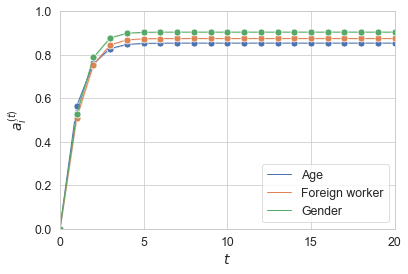

hyperbolic


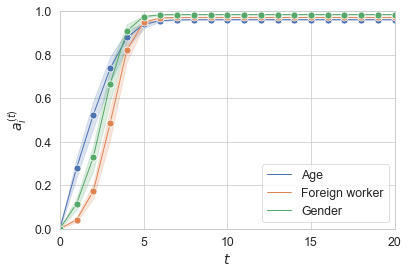

rescaled


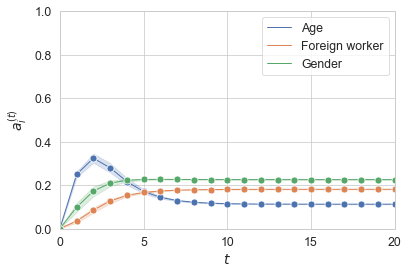

In [8]:
case = "age"
functions = [sigmoid, hyperbolic, rescaled]

for i,func in enumerate(functions):
    
    df = pd.DataFrame(columns=["var","t","value"])
    
    for i in range(20):
        
        f9 = np.random.uniform(0.0,1.0)
        f14 = np.random.uniform(0.0,1.0)
        f15 = np.random.uniform(0.0,1.0)
        
        A = np.array([[0, 0, 0, 0, 0, 0, 0, 0, f9, 0, 0, 0, 0, f14, f15, 0, 0, 0, 0, 0]])
        
        state = reasoning(W0, A, phi=1, T=21, plot=False, function=func)

        data_age = state[0,:,0]
        data_foreign = state[0,:,4]
        data_gender = state[0,:,12]
        
        df1 = pd.DataFrame(columns=["var","t","value"])
        df1["t"] = range(len(data_age))
        df1["value"] = data_age.tolist()
        df1["var"] = "Age"
        
        df2 = pd.DataFrame(columns=["var","t","value"])
        df2["t"] = range(len(data_foreign))
        df2["value"] = data_foreign.tolist()
        df2["var"] = "Foreign worker"
        
        df3 = pd.DataFrame(columns=["var","t","value"])
        df3["t"] = range(len(data_gender))
        df3["value"] = data_gender.tolist()
        df3["var"] = "Gender"
        
        df = pd.concat([df,df1,df2,df3], ignore_index=True)
    
    plt.figure(figsize=(6,4))
    ax = plt.gca()
    sns.lineplot(data=df, x="t", y="value", hue="var", ax=ax, marker='o')
    plt.xlabel(r'$t$', fontsize=14)
    plt.ylabel(r'$a_i^{(t)}$', fontsize=14)
    plt.ylim(0, 1.0)
    ax.xaxis.get_major_locator().set_params(integer=True)
    plt.legend(loc='best')
    plt.margins(x=0)
    f = str(func).split(" ")[1]
    plt.savefig(case + "_A_" + f + ".pdf", bbox_inches='tight')
    print(f)
    plt.show()

## Comparison against SOTA

We randomly activate some unprotected features. The choice of variables is irrelevant since we will use $\phi=1.0$ and therefore the output of the FCM will be the same for any initial activation vector. The simulation results are shown below.

In [9]:
df = abs(pd.read_csv('correlation_group.csv'))
W0 = df.to_numpy().reshape(len(df.columns), len(df.columns))

names = df.columns.tolist()
print(names)
df.head()

['Credit_amount', 'Credit_history', 'Duration_in_month', 'Foreign_worker_no', 'Foreign_worker_yes', 'Housing', 'Installment_rate_in_percentage_of_disposable_income', 'Job', 'Number_of_existing_credits_at_this_bank', 'Number_of_people_being_liable_to_provide_maintenance_for', 'Other_debtorsguarantors', 'Other_installment_plans', 'Present_employment_since', 'Present_residence_since', 'Property', 'Purpose', 'Savings_accountbonds', 'Status_of_existing_checking_account', 'Telephone', 'age_from_30d2_le_41d4', 'age_from_41d4_le_52d6', 'age_gt_52d6', 'age_le_30d2', 'personal_status_female_div_or_dep_or_mar', 'personal_status_male_div_or_sep', 'personal_status_male_mar_or_wid', 'personal_status_male_single']


,Credit_amount,Credit_history,Duration_in_month,Foreign_worker_no,Foreign_worker_yes,Housing,Installment_rate_in_percentage_of_disposable_income,Job,Number_of_existing_credits_at_this_bank,Number_of_people_being_liable_to_provide_maintenance_for,...,Status_of_existing_checking_account,Telephone,age_from_30d2_le_41d4,age_from_41d4_le_52d6,age_gt_52d6,age_le_30d2,personal_status_female_div_or_dep_or_mar,personal_status_male_div_or_sep,personal_status_male_mar_or_wid,personal_status_male_single
0,1.00,0.04,0.62,0.00,0.00,0.04,0.27,0.11,0.02,0.00,...,0.02,0.08,0.00,0.00,0.00,0.00,0.01,0.00,0.02,0.02
1,0.04,1.00,0.04,0.07,0.07,0.10,0.01,0.07,0.35,0.10,...,0.14,0.07,0.08,0.11,0.06,0.18,0.12,0.02,0.09,0.14
2,0.62,0.04,1.00,0.02,0.02,0.04,0.07,0.05,0.01,0.00,...,0.01,0.03,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.01
3,0.00,0.07,0.02,1.00,0.99,0.07,0.01,0.10,0.00,0.07,...,0.08,0.10,0.04,0.01,0.02,0.01,0.04,0.01,0.04,0.02
4,0.00,0.07,0.02,0.99,1.00,0.07,0.01,0.10,0.00,0.07,...,0.08,0.10,0.04,0.01,0.02,0.01,0.04,0.01,0.04,0.02


In [10]:
case = "group"
phi = 1

age1 = names.index("age_from_30d2_le_41d4")
age2 = names.index("age_from_41d4_le_52d6")
age3 = names.index("age_gt_52d6")
age4 = names.index("age_le_30d2")

for_no = names.index("Foreign_worker_no")
for_yes = names.index("Foreign_worker_yes")

gen_fem = names.index("personal_status_female_div_or_dep_or_mar")
gen_male1 = names.index("personal_status_male_div_or_sep")
gen_male2 = names.index("personal_status_male_mar_or_wid")
gen_male3 = names.index("personal_status_male_single")
    
df = pd.DataFrame(columns=["var","t","value"])

for i in range(20):

    v1 = np.random.uniform(0.0,1.0)
    v2 = np.random.uniform(0.0,1.0)
    v3 = np.random.uniform(0.0,1.0)

    A = np.array([np.zeros(len(names))])
    A[0, names.index("Telephone")] = v1
    A[0, names.index("Housing")] = v2
    A[0, names.index("Purpose")] = v3

    state = reasoning(W0, A, phi=phi, T=21, plot=False)

    data_age_1 = state[0,:,age1]
    data_age_2 = state[0,:,age2]
    data_age_3 = state[0,:,age3]
    data_age_4 = state[0,:,age4]
    
    data_foreign_no = state[0,:,for_no]
    data_foreign_yes = state[0,:,for_yes]
    
    data_gender_female = state[0,:,gen_fem]
    data_gender_male1 = state[0,:,gen_male1]
    data_gender_male2 = state[0,:,gen_male2]
    data_gender_male3 = state[0,:,gen_male3]
    
    df1 = pd.DataFrame(columns=["var","t","value"])
    df1["t"] = range(len(data_age_1))
    df1["value"] = data_age_1.tolist()
    df1["var"] = "age_from_30_le_41"
    
    df2 = pd.DataFrame(columns=["var","t","value"])
    df2["t"] = range(len(data_age_2))
    df2["value"] = data_age_2.tolist()
    df2["var"] = "age_from_41_le_52"
    
    df3 = pd.DataFrame(columns=["var","t","value"])
    df3["t"] = range(len(data_age_3))
    df3["value"] = data_age_3.tolist()
    df3["var"] = "age_gt_52"
    
    df4 = pd.DataFrame(columns=["var","t","value"])
    df4["t"] = range(len(data_age_4))
    df4["value"] = data_age_4.tolist()
    df4["var"] = "age_le_30"
    
    df5 = pd.DataFrame(columns=["var","t","value"])
    df5["t"] = range(len(data_foreign_no))
    df5["value"] = data_foreign_no.tolist()
    df5["var"] = "foreign_no"

    df6 = pd.DataFrame(columns=["var","t","value"])
    df6["t"] = range(len(data_foreign_yes))
    df6["value"] = data_foreign_yes.tolist()
    df6["var"] = "foreign_yes"

    df7 = pd.DataFrame(columns=["var","t","value"])
    df7["t"] = range(len(data_gender_female))
    df7["value"] = data_gender_female.tolist()
    df7["var"] = "gender_female"
    
    df8 = pd.DataFrame(columns=["var","t","value"])
    df8["t"] = range(len(data_gender_male1))
    df8["value"] = data_gender_male1.tolist()
    df8["var"] = "gender_male_div_or_sep"
    
    df9 = pd.DataFrame(columns=["var","t","value"])
    df9["t"] = range(len(data_gender_male2))
    df9["value"] = data_gender_male2.tolist()
    df9["var"] = "gender_male_mar_or_wid"
    
    df10 = pd.DataFrame(columns=["var","t","value"])
    df10["t"] = range(len(data_gender_male3))
    df10["value"] = data_gender_male3.tolist()
    df10["var"] = "gender_male_single"
    
    df = pd.concat([df,df1,df2,df3,df4,df5,df6,df7,df8,df9,df10], ignore_index=True)

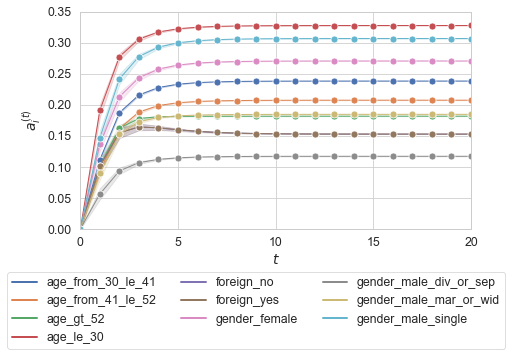

In [11]:
plt.figure(figsize=(7,4))
ax = plt.gca()
sns.lineplot(data=df, x="t", y="value", hue="var", ax=ax, marker='o')
plt.xlabel(r'$t$', fontsize=14)
plt.ylabel(r'$a_i^{(t)}$', fontsize=14)
plt.ylim(0, 0.35)
ax.xaxis.get_major_locator().set_params(integer=True)
leg = ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.17), ncol=3)
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)
plt.margins(x=0)

plt.savefig(case + ".pdf", bbox_inches='tight')

plt.show()